 <!-- SVM, Small VGG Network, ArcFace, FCapNetwork -->

In [12]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models


image_size = (160, 120, 3)
input_shape = (160, 120, 3)
num_classes = 2
num_capsules = 32  
dim_capsules = 16  
routing_iterations = 3  
kernel_size = 5  
learning_rate = 1e-5  
dataset_path = "data"


print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


Step 1: Loading DataSet, LG Folder - 29 Subjects, with one corrupt sample

In [13]:
def load_images_from_folder(folder_path, max_depth=5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                            img = cv2.resize(img, (160, 120))
                            img = np.expand_dims(img, axis=-1)
                            images.append(img)
                            # Binary label, '0' means Fit for Duty, others alcoholic
                            labels.append(file[6] != '0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
        else:
            del dirs[:]

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")


Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 120, 160, 1)


Randome index: 148


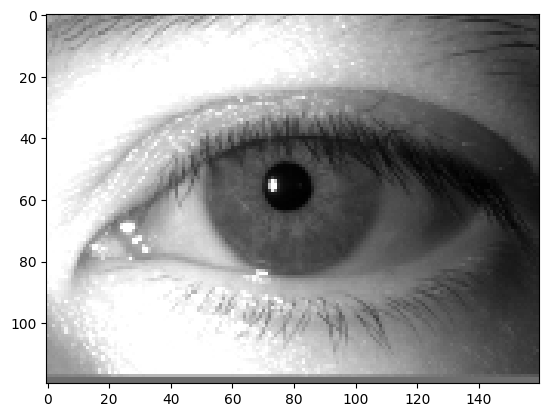

In [14]:
ri = random.randint(0, len(images) - 1)
print("Randome index: " + str(ri))
plt.imshow(images[ri], cmap='gray')

Step 2: Split images and labels into 80-20 random train test split and train cnn

In [15]:
# Split the dataset into 70% train and 30% test
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Normalize the image data
images_train = images_train / 255.0
images_test = images_test / 255.0


labels_train_cnn = to_categorical(labels_train, num_classes=2)
labels_test_cnn = to_categorical(labels_test, num_classes=2)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routing_iterations=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routing_iterations = routing_iterations

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.dim_capsules],
                                 initializer='glorot_uniform', trainable=True, name='W')

    def call(self, inputs):
        inputs_expand = tf.expand_dims(inputs, 2)
        inputs_hat = tf.einsum('...ij,jk->...ik', inputs_expand, self.W)
        inputs_hat = tf.reshape(inputs_hat, [-1, inputs.shape[1], self.num_capsules, self.dim_capsules])
        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], tf.shape(inputs_hat)[1], self.num_capsules])

        for i in range(self.routing_iterations):
            c = tf.nn.softmax(b, axis=2)
            s = tf.reduce_sum(c[..., tf.newaxis] * inputs_hat, axis=1)
            v = self.squash(s)
            if i < self.routing_iterations - 1:
                b += tf.reduce_sum(inputs_hat * v[:, tf.newaxis, :, :], axis=-1)

        return v

    def squash(self, s):
        s_squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * s / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsules, self.dim_capsules)

In [17]:
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + tf.keras.backend.epsilon())

In [18]:
class Mask(layers.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list:
            inputs, mask = inputs
        else:
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        return tf.keras.backend.batch_flatten(inputs * tf.expand_dims(mask, -1))

In [19]:
def CapsNet(input_shape, n_class, num_routing):
    x = layers.Input(shape=input_shape)

    conv1 = layers.Conv2D(256, 9, strides=1, padding='valid', activation='relu', name='conv1')(x)
    conv2 = layers.Conv2D(256, 9, strides=2, padding='valid', activation='relu', name='conv2')(conv1)

    primary_caps = layers.Conv2D(32 * 8, 9, strides=2, padding='valid', activation='relu', name='primary_caps')(conv2)
    primary_caps = layers.Reshape([-1, 8], name='primary_caps_reshape')(primary_caps)
    primary_caps = layers.Lambda(squash, name='primary_caps_squash')(primary_caps)

    digit_caps = CapsuleLayer(num_capsules=n_class, dim_capsules=16, routing_iterations=num_routing, name='digit_caps')(primary_caps)

    out_caps = Length(name='out_caps')(digit_caps)

    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digit_caps, y])
    masked = Mask()(digit_caps)

    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16 * n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    return train_model, eval_model

def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    return scale * vectors / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())

In [20]:
print(f"Train images count: {len(images_train)}")
print(f"Image Shape {images_train[0].shape}")
print(f"Test images count: {len(images_test)}")

Train images count: 1974
Image Shape (120, 160, 1)
Test images count: 846


In [21]:
def margin_loss(y_true, y_pred):
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, 1))

In [ ]:
input_shape = (120, 160, 1)
num_classes = 2
num_routing = 3

train_model, eval_model = CapsNet(input_shape, num_classes, num_routing)

train_model.compile(optimizer='adam',
                    loss=[margin_loss, 'mse'],
                    loss_weights=[1., 0.392],
                    metrics={'out_caps': 'accuracy'})

train_model.fit([images_train, labels_train_cnn], [labels_train_cnn, images_train],
                batch_size=64, epochs=10, validation_data=([images_test, labels_test_cnn], [labels_test_cnn, images_test]))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


In [ ]:
#Testing model
cnn_loss, cnn_accuracy = cnn_model.evaluate(images_test, labels_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

In [ ]:
predictions = cnn_model.predict(images_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test_cnn, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

Demonstration

In [ ]:
totalTest = 0
correctTest = 0

In [ ]:
# testImagePath = 'images/test2.png'
# testImg = cv2.imread(testImagePath, cv2.IMREAD_GRAYSCALE)

r_in = random.randint(0, len(images) - 1)

testImg = images[r_in]
testLabel = labels[r_in]
# testImg = cv2.resize(testImg, image_size)

plt.imshow(testImg, cmap='gray')

testImg = np.expand_dims(testImg, axis=0)

print(testImg.shape)

prediction = cnn_model.predict(testImg)
prediction = np.argmax(prediction[0])

totalTest +=1
correctTest += prediction==testLabel

prediction = 'Alcoholic' if prediction else 'Fit for duty'
testLabel = 'Alcoholic' if testLabel else 'Fit for duty'
plt.title(f'Name: {names[r_in]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest/totalTest}')

In [ ]:
cnn_model.save("./Models/ResNet50Classification/NonAugmented.keras")